''

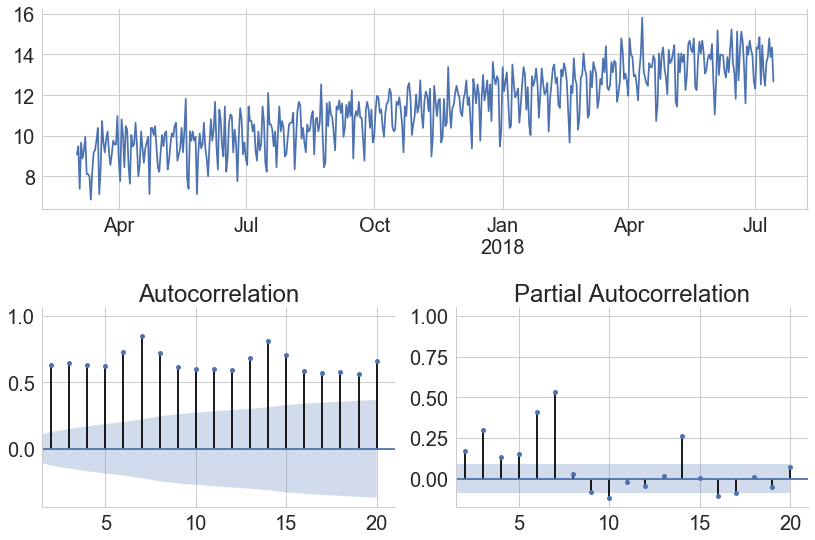

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import boxcox
import statsmodels.tsa.api as smt
from utils import poisson_process, plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [12, 8]})

λ = 200  
n = int(100000)  
t0 = pd.to_datetime('2017-03-01') 
freq = '1D'
thinning_components = [
    {'function': poisson_process._trend, 
     'params': {'percent_increase': 1.0, 'period': 365}},
    {'function': poisson_process._cyclical, 
     'params': {'weekday_factor': [1, 1, 1, 1, 1, 0.75, 0.75]}},
    {'function': poisson_process._seasonal, 
     'params': {'peak_time': '09:00:00', 'amplitude': 0.75}}]

nhpp = poisson_process.nhpp(λ, n, t0, freq, thinning_components)
nhpp_bc, λ_bc = boxcox(nhpp)
nhpp_bc = pd.Series(nhpp_bc, index=nhpp.index, name='transactions')

plotting.tsplot(nhpp_bc, lags=20)
''

### Testing for Stationarity

In [18]:
import statsmodels.tsa.api as smt
smt.adfuller(nhpp_bc)

(-1.0652843554507179,
 0.72871575782842646,
 14,
 485,
 {'1%': -3.4439051505128342,
  '10%': -2.5699539005207779,
  '5%': -2.8675177321998131},
 1083.6330094891273)

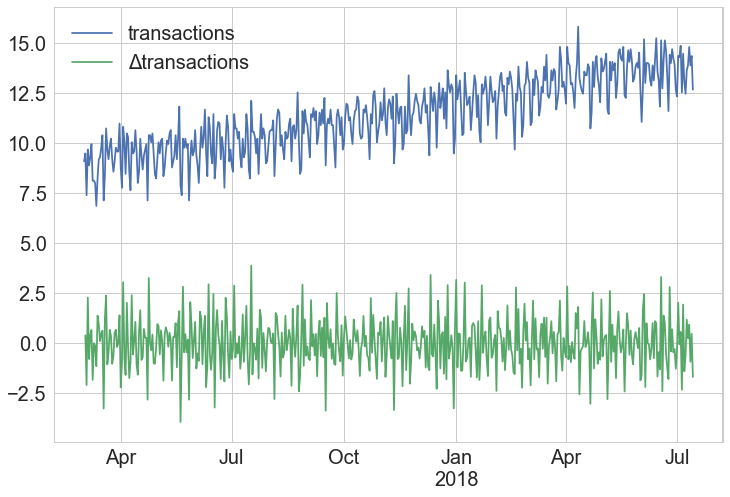

In [19]:
df_nhpp = (nhpp_bc.to_frame()
                  .assign(Δtransactions=lambda x: x['transactions'].diff())
                  .assign(days_since_start=lambda x: (x.index - min(nhpp.index)).days))
df_nhpp[['transactions', 'Δtransactions']].plot()

In [20]:
smt.adfuller(df_nhpp['Δtransactions'].dropna())

(-12.070570140242978,
 2.3530799601653812e-22,
 13,
 485,
 {'1%': -3.4439051505128342,
  '10%': -2.5699539005207779,
  '5%': -2.8675177321998131},
 1080.5368646486977)

### Finding a Best-Fit SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                      transactions   No. Observations:                  500
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -514.523
Date:                           Thu, 07 Dec 2017   AIC                           1041.046
Time:                                   00:43:57   BIC                           1066.333
Sample:                               03-02-2017   HQIC                          1050.968
                                    - 07-14-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0629      0.046     -1.375      0.169      -0.152       0.027
ar.L2         -0.0986      0.049     -2.031      0.042      -0.194      -0.003
ma.L1         -0.9662      0.013    -75.824      0.000      -0.991      -0.941
ar.S.L7        0.9996      0.001   1602.365      0.000       0.998       1.001
ma.S.L7       -0.9670      0.025    -38.726      0.000      -1.016      -0.918
sigma2         0.4381      0.027     16.152      0.000       0.385       0.491
===================================================================================
Ljung-Box (Q):                       36.22   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.64   Prob(JB):                         0.70
Heteroskedasticity (H):               0.83   Skew:                            -0.04
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

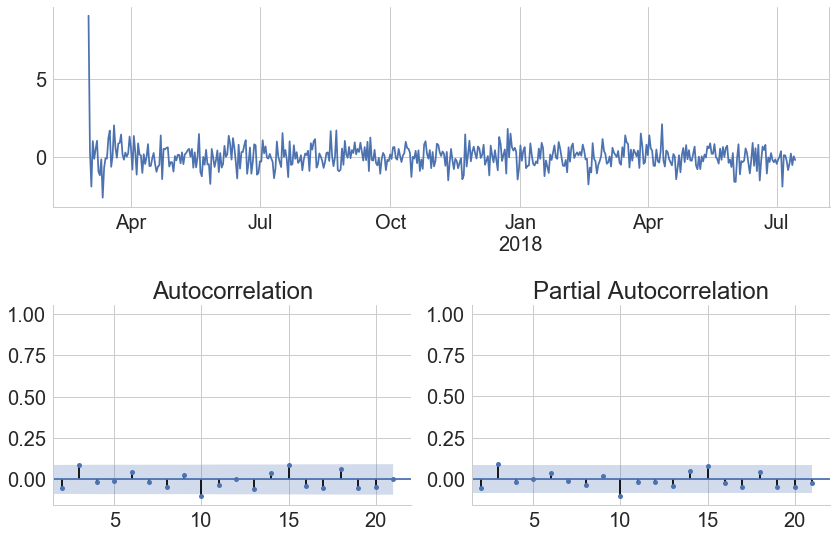

In [135]:
import statsmodels.tsa.api as smt
from utils import plotting
mod = smt.SARIMAX(nhpp_bc, order=(2, 1, 1), seasonal_order=(1, 0, 1, 7))
res = mod.fit()
plotting.tsplot(res.resid, lags=21)
res.summary()

''

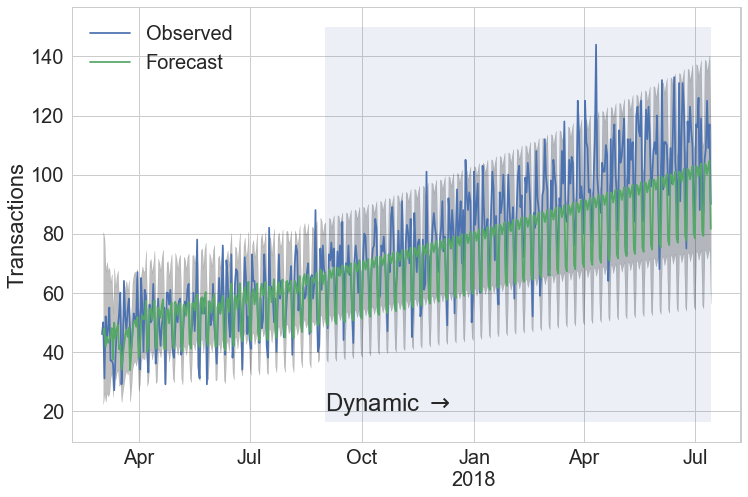

In [148]:
# Get the predictions, and forecast beyond dynamic_start
dynamic_start = '2017-09-01'
pred = res.get_prediction(start='2017-03-03', end=max(nhpp.index), dynamic=dynamic_start)

# Undo the Box-Cox transformation
predictions = (λ_bc * pred.predicted_mean + 1) ** (1/ λ_bc)
predictions_bounds = (λ_bc * pred.conf_int() + 1) ** (1 / λ_bc)

# Plot the time series and the forecast
ax = nhpp.plot(label='Observed')
predictions.plot(ax=ax, label='Forecast')
ax.fill_between(predictions.index,
                predictions_bounds.iloc[:, 0],
                predictions_bounds.iloc[:, 1], color='k', alpha=.25)

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp(dynamic_start), predictions.index[-1], alpha=0.1)
ax.annotate('Dynamic $\\rightarrow$', (pd.Timestamp(dynamic_start), 20))
ax.set_ylabel('Transactions')
plt.legend()
''